In [ ]:
# !pip install PIL 
# !pip install pytesseract
# !pip install 

ADD

    -> TRY EXCEPT 
    -> CHOOSE THE ENVIRONNEMENT OF THE CRISIS IF TOO LONG
    -> CHECK THE INDIVIDUALS WITH 23 CHANNELS 

In [1]:
import torch 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import torchvision 

c:\Users\rayan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np 
import torch
import mne
import matplotlib.pyplot as plt 
import os 
import mne
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.autograd as autograd

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

## Importation & Pre-processing

In [5]:


# Chemin vers le dossier parent
dossier_parent = "C:/Users/rayan/Desktop/B_Laval/S2/Cours/Apprentissage_NeuronesProfonds/Projet_2/EEG_Seizures_Transformers-/data"

# Dictionnaire pour stocker les données MNE par sous-dossier
donnees_par_sous_dossier = {}

# Parcours des sous-dossiers
for nom_sous_dossier in os.listdir(dossier_parent):
    
    chemin_sous_dossier = os.path.join(dossier_parent, nom_sous_dossier)
    
    if os.path.isdir(chemin_sous_dossier):
        
        donnees_par_sous_dossier[nom_sous_dossier] = []
        
        for nom_fichier in os.listdir(chemin_sous_dossier):
            
            if nom_fichier.endswith('.edf'):
                
                chemin_fichier = os.path.join(chemin_sous_dossier, nom_fichier)
                donnees_mne = mne.io.read_raw_edf(chemin_fichier)
                donnees_par_sous_dossier[nom_sous_dossier].append(donnees_mne)

# Affichage des informations sur les données MNE
for nom_sous_dossier, donnees_mne in donnees_par_sous_dossier.items():
    print(f"Sujet {nom_sous_dossier} : {len(donnees_mne)} fichiers .edf")




Sujet chb-mit-scalp-eeg-database-1.0.0 : 0 fichiers .edf


In [ ]:
# X = list(donnees_par_sous_dossier.keys())
# Y = list(len(elem) for elem in donnees_par_sous_dossier.values())

# # Création de l'histogramme
# plt.figure(figsize=(10, 6))
# plt.bar(X,Y, color='skyblue')
# plt.xlabel('Sujets')
# plt.ylabel('Nombre d\'enregistrements')
# plt.title('Nombre d\'enregistrements par sujet')
# plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
# plt.tight_layout()  # Ajustement automatique du tracé pour éviter les chevauchements
# plt.show()





### Temps d'échantillonnage - Nombre d'enregistrements n'ayant pas une durée de 1 heure par sujet 

In [6]:
# Dictionnaire pour stocker le nombre de fichiers par sous-dossier
nombre_par_sous_dossier = {}

# Parcours des sous-dossiers
for nom_sous_dossier, donnees_mne_liste in donnees_par_sous_dossier.items():
    # Initialisation du compteur pour ce sous-dossier
    cpt = 0
    # Parcours des données MNE dans ce sous-dossier
    for donnees_mne in donnees_mne_liste:
        # Vérification si la durée de la donnée MNE est inférieure à la valeur donnée
        if donnees_mne.times[-1] < 3599.99609375:
            # Incrémentation du compteur
            cpt += 1
    # Stockage du nombre dans le dictionnaire
    nombre_par_sous_dossier[nom_sous_dossier] = cpt

# Affichage du nombre de fichiers qui satisfont la condition pour chaque sous-dossier
for nom_sous_dossier, nombre in nombre_par_sous_dossier.items():
    print(f"Sous-dossier {nom_sous_dossier} : {nombre} fichiers")


Sous-dossier chb-mit-scalp-eeg-database-1.0.0 : 0 fichiers


### Preprocessing

In [7]:

# Chemin d'accès au fichier
file_path = "C:/Users/rayan/Desktop/B_Laval/S2/Cours/Apprentissage_NeuronesProfonds/Projet_2/EEG_Seizures_Transformers-/data/chb-mit-scalp-eeg-database-1.0.0"


In [8]:
def read_summary(file_path):
    # Initialisation des listes pour stocker les informations
    seizure_presence = {}
    
    # Chemin d'accès au fichier
    #file_path = "chb04-summary.txt"
    
    # Ouvrir et lire le fichier
    is_seizure = False
    all_files_str = []
    seizure_start = 0
    with open(file_path, "r") as file:
        # Lire chaque ligne du fichier
        for line in file:
            # Traiter la ligne actuelle
            if line.strip():
                if "File Name:" in line:
                  start = len("File Name: ")
                  all_files_str.append(str(line[start:len(line)-1]))
                elif ("Seizure" in line) and ("Start Time: " in line):
                  if line[len("Seizure S")-1] == "S":
                    start = len("Seizure Start Time: ")
                  else:
                    start = len("Seizure 1 Start Time: ")
                  end = len(" seconds")+1
                  seizure_start = int(line[start:len(line)-end])
                elif ("Seizure"in line) and ("End Time: " in line):
                  if line[len("Seizure E")-1] == "E":
                    start = len("Seizure End Time: ")
                  else:
                    start = len("Seizure 1 End Time: ")
                  end = len(" seconds")+1
                  seizure_end = int(line[start:len(line)-end])
                  if not all_files_str[len(all_files_str)-1] in seizure_presence.keys():
                    seizure_presence[all_files_str[len(all_files_str)-1]] = []
                  seizure_presence[all_files_str[len(all_files_str)-1]].append((seizure_start, seizure_end))
    print("Seizure presence init" ,seizure_presence)
    return seizure_presence, all_files_str


def separate_data_intervals(file_str, seizure_presence,path):
  # Durée de chaque intervalle en secondes (2 minutes)
  interval_duration = 10

  raw = mne.io.read_raw_edf(path + file_str)
  #data, times = raw[:, :]
  total_duration = raw.times[-1] # en secondes

  # Nombre total d'intervalle de 10 minutes
  num_intervals = int(total_duration / interval_duration)
  labels = []
  data = []
  
  # print("Seizure presence: ", seizure_presence) 
  
  # Diviser les données en intervalles de 10 minutes
  for i in range(num_intervals):
      # Calculer le temps de début et de fin de chaque intervalle
      start_time = i * interval_duration
      end_time = (i + 1) * interval_duration
            

      # Convertir le temps en indice
      start_idx = raw.time_as_index(start_time)
      end_idx = raw.time_as_index(end_time)

      # Extraire les données de l'intervalle
      interval_data, interval_times = raw[:, start_idx:end_idx]
      data.append(interval_data)

      
      if file_str in seizure_presence.keys():
        is_seizure = False
        for start_seizure, end_seizure in seizure_presence[file_str]:


          if (start_seizure >= start_time and start_seizure <= end_time) or (end_seizure >= start_time and end_seizure <= end_time) or (start_seizure <= start_time and end_seizure >= end_time):
                
            is_seizure = True
  
            break
        if is_seizure:
          labels.append(1)
        else:
          labels.append(0)
      else:
        labels.append(0)
  return data, labels



In [9]:
def load_data_for_patient(file_path, patient):
      
    path = file_path +"/"+ patient + "/"
    seizure_presence, all_files_str = read_summary(path+patient+"-summary.txt")
    data = []
    labels = []
    for file in all_files_str:
      try :
        interval_data, label = separate_data_intervals(file, seizure_presence,path)
        for i in range(len(interval_data)):
          data.append(interval_data[i])
          labels.append(label[i])
      except Exception as e:
        print("Error while reading file : ", file)
        print(e)
    return data, labels

In [10]:
# plot the data for a patient 
import mne

def plot_patient_record(file_path,patient_record,duration,channel_names=None, duration_min=None,duration_max=None):
    raw = mne.io.read_raw_edf(file_path + "/" + patient_record, preload=True)

    original_channel_names = raw.info['ch_names'].copy()
    # shape 
    print(raw.get_data().shape)
    # print the time of the record
    print(raw.n_times)
    
        
    if channel_names is not None:
        raw.rename_channels(dict(zip(original_channel_names, channel_names)))
    else:
        channel_names = original_channel_names   
    
    if duration_min is not None and duration_max is None:
        

        raw.crop(tmin=duration_min)
        raw.plot(duration=duration, n_channels=23, scalings={"eeg": 75e-5}, title="Patient Record", show=True, block=True)
        
    elif duration_min is None and duration_max is not None:
        # Create an event array with a single event at 700 seconds
        raw.crop(tmin = duration_min,tmax=duration_max)
        raw.plot(duration=duration, n_channels=23, scalings={"eeg": 75e-5}, title="Patient Record",xlim=(duration_min, duration_max), show=True, block=True)

        
    elif duration_min is not None and duration_max is not None:
        
        raw.crop(tmin=duration_min , tmax=duration_max)
        raw.plot(duration=duration, n_channels=23, scalings={"eeg": 75e-5}, title="Patient Record",  show=True, block=True)

        
    else :
        raw.plot(duration=duration, n_channels=23, scalings={"eeg": 100e-5}, title="Patient Record", show=True, block=True)

    return raw.get_data()
        

Extracting EDF parameters from C:\Users\rayan\Desktop\B_Laval\S2\Cours\Apprentissage_NeuronesProfonds\Projet_2\EEG_Seizures_Transformers-\data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\rayan\AppData\Local\Temp\ipykernel_16872\2380645811.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path + "/" + patient_record, preload=True)


(23, 921600)
921600
Using matplotlib as 2D backend.


KeyboardInterrupt: 

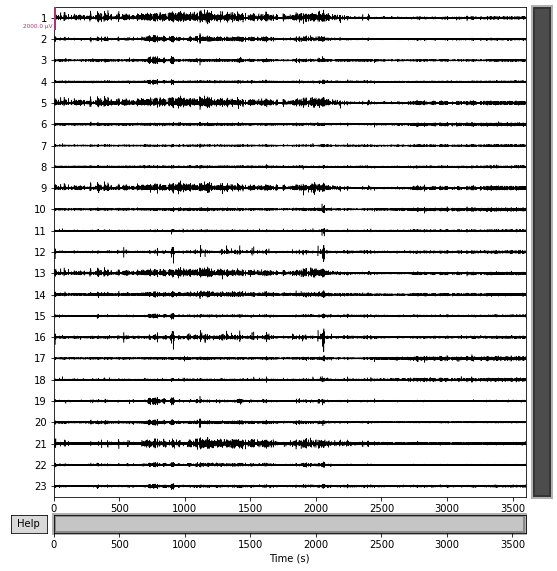

In [11]:
data_1 = plot_patient_record(file_path,"./chb01/chb01_02.edf",duration = 3599, channel_names = [str(idx) for idx in range(1, 24)])
data_2 = plot_patient_record(file_path,"./chb01/chb01_03.edf",duration = 3599, channel_names = [str(idx) for idx in range(1, 24)])
# plot_patient_record(file_path,"./chb01/chb01_03.edf",channel_names = [str(idx) for idx in range(1, 24)], duration_min=2900, duration_max=3100)

Exemple des crises des patients :

    -> patient 2, enregistrement 16, entre 130s et 212s 
    -> patient 3, enregistrement 2, entre 731s et 796s

In [12]:
data_2_16_all = plot_patient_record(file_path,"./chb02/chb02_16.edf",duration = 3599, channel_names = [str(idx) for idx in range(1, 24)])
data_2_crise_16 = plot_patient_record(file_path,"./chb02/chb02_16.edf",duration = 3599, channel_names = [str(idx) for idx in range(1, 24)],duration_min = 80, duration_max = 262)

data_3_all = plot_patient_record(file_path,"./chb03/chb03_02.edf",duration = 3599, channel_names = [str(idx) for idx in range(1, 24)])
data_3_crise_2 = plot_patient_record(file_path,"./chb03/chb03_02.edf",duration = 3599, channel_names = [str(idx) for idx in range(1, 24)],duration_min = 681, duration_max = 846)

Extracting EDF parameters from C:\Users\rayan\Desktop\B_Laval\S2\Cours\Apprentissage_NeuronesProfonds\Projet_2\EEG_Seizures_Transformers-\data\chb-mit-scalp-eeg-database-1.0.0\chb02\chb02_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245503  =      0.000 ...   958.996 secs...
(23, 245504)
245504


C:\Users\rayan\AppData\Local\Temp\ipykernel_16872\2380645811.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path + "/" + patient_record, preload=True)


KeyboardInterrupt: 

In [11]:
import warnings 

warnings.filterwarnings("ignore")
mne.set_log_level(verbose=False)

In [ ]:
import warnings 

warnings.filterwarnings("ignore")
mne.set_log_level(verbose=False)

data , labels = load_data_for_patient(file_path,"chb01")
print("Data length : ", len(data))
print("Labels length : ", len(labels))

In [ ]:
data = np.array(data)

In [ ]:
data.shape

Les dimensions sont bonnes étant donné que nous avons pris 10 secondes, nous aurons 10xpas de temps = 10x256 = 2560 valeurs par channel pour un segment. 

In [12]:
patients_1 = ["chb01","chb02","chb03"]
patients_2 = ["chb06","chb05"]
patients_3 = ["chb07"]
patients_4 = ["chb23","chb24"]

data_1 = []
data_2 = []
data_3 = []
data_4 = []


labels_1 = []
labels_2 = []
labels_3 = []
labels_4 = []



In [13]:
import pickle
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
import pickle

# tous les patients non pris en compte sont ceux qui utilisent des channels différents 



patients = ["chb01", "chb02", "chb03", "chb05", "chb07", "chb08", "chb09", "chb10", "chb11", "chb12", "chb13", "chb14", "chb15", "chb16", "chb17", "chb18", "chb19", "chb20", "chb21", "chb22", "chb23", "chb24"]

patients_1 = ["chb01","chb02","chb03"]
patients_2 = ["chb06","chb05"]
patients_3 = ["chb07"]
patients_4 = ["chb23","chb24","chb08"]



def load_data(file_path, patients):
    
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    
    for patient in patients :
        data = []
        labels = []
        for i in range(2) :
            try :
                data_, labels_ = load_data_for_patient(file_path, patient)
                data.extend(data_)
                labels.extend(labels_)
            except Exception as e:
                print("Error for patient", patient)
                print(e)
        
        data = np.array(data)
        labels = np.array(labels)
        print("Data shape : ", data.shape)
        train_data_3, test_data_3, train_labels_3, test_labels_3 = train_test_split(data, labels, test_size=0.2, random_state=42)
        
        train_data.append(train_data_3)
        train_labels.append(train_labels_3)
        test_data.append(test_data_3)
        test_labels.append(test_labels_3)
        
    return train_data, train_labels, test_data, test_labels


for i in range(len(patients_1)) :
            try :
                print("Patient", patients_1[i])
                data_, labels_ = load_data_for_patient(file_path, patients_1[i])
                data_1.extend(data_)
                labels_1.extend(labels_)
            except Exception as e:
                print("Error for patient", patients_1[i])
                print(e)
                
all_data = { "data_1" : data_1, "labels_1" : labels_1}
                

for key, value in all_data.items():
    file_path_ = "./saved_data/"+key+".pkl"
    with open(file_path_, "wb") as f:
        pickle.dump(value, f)
    print("Data saved successfully for", key)
    
            
len(data_1), len(labels_1)


In [ ]:
for i in range(len(patients_2)) :
            try :
                print("Patient", patients_2[i])
                data_, labels_ = load_data_for_patient(file_path, patients_2[i])
                data_2.extend(data_)
                labels_2.extend(labels_)
            except Exception as e:
                print("Error for patient", patients_2[i])
                print(e)
                
all_data = { "data_2" : data_2, "labels_2" : labels_2}

# for key, value in all_data.items():
#     file_path_ = "./saved_data/"+key+".pkl"
#     with open(file_path_, "wb") as f:
#         pickle.dump(value, f)
#     print("Data saved successfully for", key)
    

len(data_2), len(labels_2)

In [ ]:
patients_3

In [ ]:
for i in range(len(patients_3)) :

            try :
                print("Patient", patients_3[i])
                data_, labels_ = load_data_for_patient(file_path, patients_3[i])
                data_3.extend(data_)
                labels_3.extend(labels_)
            except Exception as e:
                print("Error for patient", patients_3[i])
                print(e)
                
                
all_data = { "data_3" : data_3, "labels_3" : labels_3}

In [ ]:
for key, value in all_data.items():
    file_path_ = "./saved_data/"+key+".pkl"
    with open(file_path_, "wb") as f:
        pickle.dump(value, f)
    print("Data saved successfully for", key)
    
len(data_3), len(labels_3)

In [17]:
for i in range(len(patients_4)) :
            try :
                print("Patient", patients_4[i])
                data_, labels_ = load_data_for_patient(file_path, patients_4[i])
                data_4.extend(data_)
                labels_4.extend(labels_)
            except Exception as e:
                print("Error for patient", patients_4[i])
                print(e)
                
all_data = { "data_4" : data_4, "labels_4" : labels_4}

Patient chb23
Seizure presence init {'chb23_06.edf': [(3962, 4075)], 'chb23_08.edf': [(325, 345), (5104, 5151)], 'chb23_09.edf': [(2589, 2660), (6885, 6947), (8505, 8532), (9580, 9664)]}
Patient chb24
Seizure presence init {'chb24_01.edf': [(480, 505), (2451, 2476)], 'chb24_03.edf': [(231, 260), (2883, 2908)], 'chb24_04.edf': [(1088, 1120), (1411, 1438), (1745, 1764)], 'chb24_06.edf': [(1229, 1253)], 'chb24_07.edf': [(38, 60)], 'chb24_09.edf': [(1745, 1764)], 'chb24_11.edf': [(3527, 3597)], 'chb24_13.edf': [(3288, 3304)], 'chb24_14.edf': [(1939, 1966)], 'chb24_15.edf': [(3552, 3569)], 'chb24_17.edf': [(3515, 3581)], 'chb24_21.edf': [(2804, 2872)]}


In [18]:
for key, value in all_data.items():
    file_path_ = "./saved_data/"+key+".pkl"
    with open(file_path_, "wb") as f:
        pickle.dump(value, f)
    print("Data saved successfully for", key)

len(data_4), len(labels_4)

Data saved successfully for data_4
Data saved successfully for labels_4


(13862, 13862)

In [14]:
import pickle

#  Load the data from the file
with open("./saved_data/data_1.pkl", "rb") as f:
    data_1 = pickle.load(f)
with open("./saved_data/labels_1.pkl", "rb") as f:
    labels_1 = pickle.load(f)

# Now, 'loaded_data' contains the data you previously saved
print("Data loaded successfully!")
len(data_1),len(labels_1)

Data loaded successfully!


(40861, 40861)

In [38]:
with open("./saved_data/data_2.pkl", "rb") as f:
    data_2 = pickle.load(f)
with open("./saved_data/labels_2.pkl", "rb") as f:
    labels_2 = pickle.load(f)

# Now, 'loaded_data' contains the data you previously saved
print("Data loaded successfully!")
len(data_2),len(labels_2)

MemoryError: 

In [39]:
with open("./saved_data/data_3.pkl", "rb") as f:
    data_3 = pickle.load(f)
with open("./saved_data/labels_3.pkl", "rb") as f:
    labels_3 = pickle.load(f)

# Now, 'loaded_data' contains the data you previously saved
print("Data loaded successfully!")
len(data_3),len(labels_3)

Data loaded successfully!


(24122, 24122)

In [40]:
with open("./saved_data/data_4.pkl", "rb") as f:
    data_4 = pickle.load(f)
with open("./saved_data/labels_4.pkl", "rb") as f:
    labels_4 = pickle.load(f)
    
# Now, 'loaded_data' contains the data you previously saved
print("Data loaded successfully!")
len(data_4),len(labels_4)

MemoryError: 

In [ ]:
all_data_names = ["data_1", "data_2", "data_3", "data_4","labels_1", "labels_2", "labels_3", "labels_4"]


In [42]:
len(data_1),len(data_2), len(data_3), len(data_4), len(labels_1), len(labels_2), len(labels_3), len(labels_4)

(40861, 0, 24122, 0, 40861, 0, 24122, 0)

In [43]:
all_data = [data_1, data_3 ]
all_labels = [labels_1,  labels_3]

In [ ]:
# import pickle

# file_path_ = "./saved_data./data.pkl"
# file_path_label = "saved_labels.pkl"

# # Load the data from the file
# with open(file_path_, "rb") as f:
#     data = pickle.load(f)
# with open(file_path_label, "rb") as f:
#     labels = pickle.load(f)

# # Now, 'loaded_data' contains the data you previously saved
# print("Data loaded successfully!")

In [ ]:
data_1.__len__()

In [ ]:
# si la data n'est pas trop grande on peut la stocker dans un array / Pour un 1 patient par exemple

from sklearn.model_selection import train_test_split

data = np.array(data,dtype=np.float32)
labels = np.array(labels)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,shuffle = True, random_state=42)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

## Training 

In [15]:
def accuracy_fn(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    y_true = torch.argmax(y_true, dim=1)
    return (y_pred == y_true).float().mean()

In [16]:
from tqdm import tqdm

def train(loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          model: nn.Module,
          train_loader: DataLoader,
          valid_loader: DataLoader,
          epochs: int,
          early_stop_patience: int,
          device="cpu"):
    
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "valid_loss": [],
        "valid_accuracy": [],
        "epochs": [],
        "best_train_accuracy": 0,
        "best_valid_accuracy": 0,
    }
    
    best_valid_loss = float('inf')
    consecutive_no_improvement = 0
    
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_loss = 0
        train_accuracy = 0
        
        for batch in train_loader:
            

            X, y = batch
            X, y = X.to(device), y.to(device)
            # print(y.shape)
            # print(X.shape)
            # print(y.shape)
            # print(X.shape)
            y_hat = model(X)
            # print(y_hat.shape)
            
            # one hot vector 
            y = torch.nn.functional.one_hot(y, num_classes=2).float()
            
            
            
            loss = loss_fn(y_hat, y)
            
            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()

            
            train_loss += loss.item()
            train_accuracy += accuracy_fn(y_hat, y)
            
            
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["epochs"].append(epoch)
        
        print(f'Epoch {epoch + 1}: Train Loss {train_loss} and Accuracy {train_accuracy}')
        
        with torch.no_grad():
            
            model.eval()
            valid_loss = 0
            valid_accuracy = 0
            
            for batch in valid_loader:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                
                y = torch.nn.functional.one_hot(y, num_classes=2).float()
                
                loss = loss_fn(y_hat, y)
                valid_loss += loss.item()
                valid_accuracy += accuracy_fn(y_hat, y)
                
            valid_loss /= len(valid_loader)
            valid_accuracy /= len(valid_loader)
            
            history["valid_loss"].append(valid_loss)
            history["valid_accuracy"].append(valid_accuracy)
            
        print(f'Epoch {epoch + 1}: Valid Loss {valid_loss} and Valid Accuracy {valid_accuracy}')
        
        # Check for early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            if consecutive_no_improvement >= early_stop_patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
    
    best_main = max(history["train_accuracy"])
    best_valid = max(history["valid_accuracy"])
    history["best_train_accuracy"] = best_main
    history["best_valid_accuracy"] = best_valid
    history['train_accuracy'] = [i.item() for i in history['train_accuracy']]
    history['valid_accuracy'] = [i.item() for i in history['valid_accuracy']]
    print(f'Best training accuracy: {best_main}')
    print(f'Best validation accuracy: {best_valid}')
        
    print('Training finished')
    
    return history



In [17]:
from sklearn.model_selection import train_test_split


def data_into_arrays(data,labels,max_size=10000):
    data_array = np.array(data[:max_size]) # capacité max : 8.77 GiB
    labels_array = np.array(labels[:max_size]) # capacité max : 8.77 GiB
    new_data = data[max_size:]
    new_labels = labels[max_size:]
    return data_array, labels_array,new_data,new_labels

def array_to_loader(data,labels,batch_size):
    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    data = data.unsqueeze(1)
    data = data.to(device)
    labels = labels.to(device)
    dataset = torch.utils.data.TensorDataset(data, labels)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

def split_train(model,data,labels,max_size,loss_fn,optimizer,epochs=10):

    all_histories = []
    
    nbr_arrays = np.ceil(len(data)/max_size)
    
    
    for i in range(int(nbr_arrays)):
        
        data, labels, new_data, new_labels = data_into_arrays(data,labels,5000)
        
        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,shuffle = True, random_state=42)
        
        train_loader = array_to_loader(train_data,train_labels,32)
        
        test_loader = array_to_loader(test_data,test_labels,32)
        
        model = model.to(device)
        
        history = train(loss_fn, optimizer, model, train_loader, test_loader, epochs, 5, device)
        
        all_histories.append(history)
        
        if len(new_data) == 0:
            
            break
        
                
    return all_histories


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot(history,metric = "loss"):
    plt.plot(history['epochs'], history['train_'+ metric], label='train_' + metric)
    plt.plot(history['epochs'], history['valid_' + metric], label='valid_' + metric)
    # # cadrillage
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend()
    plt.show()

def plot_confusion_matrix(confusion_matrix, labels):


    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

def eval( loss_fn: nn.Module,
          model: nn.Module,
          test_loader: DataLoader,
          device="cpu"):
    
    history = {
        "test_loss": [],
        "test_accuracy": [],
    }
    
    confusion_matrix = torch.zeros(2, 2)
    
    model.eval()
    test_loss = 0
    test_accuracy = 0
    y_pred = []
    y= []
    
    
    with torch.no_grad():
        for batch in test_loader:
            X, y_ = batch
            X, y_ = X.to(device), y_.to(device)
            y_hat = model(X)
            
            y_2 = torch.nn.functional.one_hot(y_, num_classes=2).float()

            loss = loss_fn(y_hat, y_2)
            test_loss += loss.item()
            test_accuracy += accuracy_fn(y_hat, y_2).item()
            
            y.extend(y_)
            y_pred.extend(torch.argmax(y_hat,dim=1))

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    
    y_pred = [i.item() for i in y_pred]
    y = [i.item() for i in y]


    for i in range(len(y)):
        confusion_matrix[y[i]][y_pred[i]] += 1
    
        
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)
            
    print(f'Test Loss {test_loss} and Test Accuracy {test_accuracy}')
    
    return history, confusion_matrix,y_pred,y

def metrics(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[1][1]
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    
# plot la matrice de confusion mais avec le nombre de 1 qu'il fala
    

In [19]:
import math
import numpy as np
import torch
import torch.random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

### Traitement des 8000 enregistrements : 

In [22]:
import gc 

gc.collect()

0

Partie pour prendre seulement les 8000 premiers segments de signaux : 

In [20]:
data = data_1
labels = labels_1

In [21]:
max_size = 8000

data_array,labels_array,new_data,new_labels = data_into_arrays(data,labels,max_size)

train_data, test_data, train_labels, test_labels = train_test_split(data_array, labels_array, test_size=0.2)
        
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size=0.3)
            
train_loader = array_to_loader(train_data,train_labels,64)
valid_loader = array_to_loader(valid_data,valid_labels,64)
test_loader = array_to_loader(test_data,test_labels,64)

In [22]:
# info about the data
print("Train data shape : ", train_data.shape)
print("Train labels shape : ", train_labels.shape)
print("Valid data shape : ", valid_data.shape)
print("Valid labels shape : ", valid_labels.shape)
print("Test data shape : ", test_data.shape)
print("Test labels shape : ", test_labels.shape)

# proportion of labels in each
print("Proportion of 1 in train labels : ", np.sum(train_labels)/len(train_labels))
print("Proportion of 1 in valid labels : ", np.sum(valid_labels)/len(valid_labels))
print("Proportion of 1 in test labels : ", np.sum(test_labels)/len(test_labels))

print("Proportion of 1 in train and test labels : ", (np.sum(train_labels) + np.sum(test_labels) + np.sum(valid_labels)) / ((len(train_labels) + len(test_labels) + len(valid_labels))))

Train data shape :  (5120, 23, 2560)
Train labels shape :  (5120,)
Valid data shape :  (1280, 23, 2560)
Valid labels shape :  (1280,)
Test data shape :  (1600, 23, 2560)
Test labels shape :  (1600,)
Proportion of 1 in train labels :  0.0048828125
Proportion of 1 in valid labels :  0.00625
Proportion of 1 in test labels :  0.005625
Proportion of 1 in train and test labels :  0.00525


In [ ]:
len(data)

Fin de cette partie.

In [ ]:
print(f"Pour {len(data)} données")

# info about the data
print("Train data shape : ", train_data.shape)
print("Train labels shape : ", train_labels.shape)
# print("Valid data shape : ", valid_data.shape)
# print("Valid labels shape : ", valid_labels.shape)
print("Test data shape : ", test_data.shape)
print("Test labels shape : ", test_labels.shape)

# proportion of labels in each
print("Proportion of 1 in train labels : ", np.sum(train_labels)/len(train_labels))
# print("Proportion of 1 in valid labels : ", np.sum(valid_labels)/len(valid_labels))
print("Proportion of 1 in test labels : ", np.sum(test_labels)/len(test_labels))

In [22]:
# regularisarisation 
# dropout


import torch
import torch.nn as nn
from einops.layers.torch import Rearrange

class ConvolutionModule(nn.Module):
    def __init__(self, emb_size=40, nb_channels=23):
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (nb_channels, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),
            Rearrange('b e (h) (w) -> b e (h w)'),  # Rearrange operation to flatten the spatial dimensions
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.shallownet(x)
        x = self.projection(x)
        return x

# Example usage
model = ConvolutionModule()
input_tensor = torch.randn(64,1, 23, 2560)  # Example input tensor
output_tensor = model(input_tensor)
print(output_tensor.shape)


torch.Size([64, 40, 165])


Un segment est composé de 40 tokens et chaque token possède 165 valeurs. 

Tranformer plus stable mais a besoin de plus de données.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):

        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [26]:
torch.cuda.empty_cache()


In [25]:
import torch
import torch.nn as nn

class LSTM_Conv(nn.Module):
    
    def __init__(self, input_size=165, hidden_size=128, num_layers=2, num_classes=2, dropout=0.5, weight_decay=0.001):
        super(LSTM_Conv, self).__init__()
        self.conv = ConvolutionModule()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer with L2 regularization
        self.fc = nn.Linear(hidden_size, num_classes)
        # self.fc.weight_decay = weight_decay
        
    def forward(self, x):
        x = self.conv(x)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        return out


class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.conv = ConvolutionModule()
        self.gru = nn.GRU(40, 128, 2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv(x)
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x
    
    
model_lstm = LSTM_Conv().to(device)
model_gru = GRU().to(device)


loss_fn = FocalLoss()
loss_fn_2 = nn.BCEWithLogitsLoss()

optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)

In [26]:
history_1 = train(loss_fn_2, optimizer_lstm, model_lstm, train_loader, valid_loader, epochs=20, early_stop_patience=5, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.12563487539467003 and Accuracy 0.9801339507102966


  5%|▌         | 1/20 [00:44<13:58, 44.15s/it]

Epoch 1: Valid Loss 0.0217123299681892 and Valid Accuracy 0.9968750476837158
Epoch 2: Train Loss 0.036953066562169366 and Accuracy 0.9939731955528259


 10%|█         | 2/20 [01:00<08:20, 27.82s/it]

Epoch 2: Valid Loss 0.026445358991622925 and Valid Accuracy 0.9968750476837158
Epoch 3: Train Loss 0.0368478650160666 and Accuracy 0.9939731955528259


 15%|█▌        | 3/20 [01:16<06:22, 22.48s/it]

Epoch 3: Valid Loss 0.02384307744602362 and Valid Accuracy 0.9968750476837158
Epoch 4: Train Loss 0.037040508911013605 and Accuracy 0.9939731955528259


 20%|██        | 4/20 [01:32<05:20, 20.02s/it]

Epoch 4: Valid Loss 0.0243537824600935 and Valid Accuracy 0.9968750476837158
Epoch 5: Train Loss 0.03708679165824184 and Accuracy 0.9939731955528259


 25%|██▌       | 5/20 [01:49<04:40, 18.67s/it]

Epoch 5: Valid Loss 0.023232879924277465 and Valid Accuracy 0.9968750476837158
Epoch 6: Train Loss 0.030650147356625114 and Accuracy 0.9939731955528259


 25%|██▌       | 5/20 [02:05<06:16, 25.08s/it]

Epoch 6: Valid Loss 0.19964818954467772 and Valid Accuracy 0.9968750476837158
Early stopping at epoch 6
Best training accuracy: 0.9939731955528259
Best validation accuracy: 0.9968750476837158
Training finished


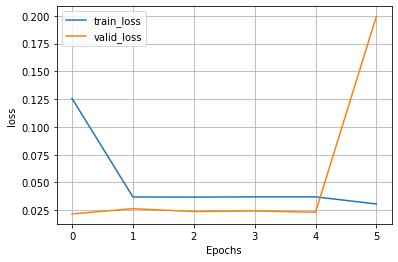

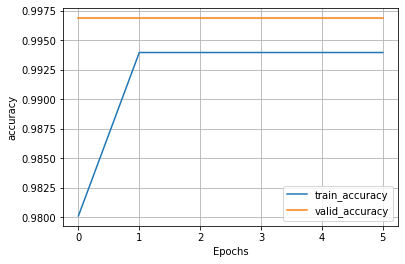

In [27]:
plot(history_1)
plot(history_1, metric="accuracy")

Test Loss 0.2035922920703888 and Test Accuracy 0.994375


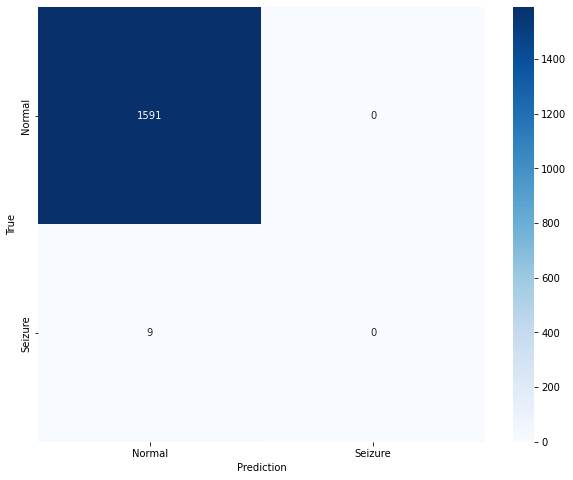

Precision: 1.0
Recall: 0.9943749904632568
F1: 0.9971795678138733


In [29]:
_,confusion_matrix_1,_,_ = eval(loss_fn_2, model_lstm, test_loader, device=device)
plot_confusion_matrix(confusion_matrix_1, ["Normal", "Seizure"])
metrics(confusion_matrix_1)

In [34]:
history = train(loss_fn, optimizer_lstm, model_lstm, train_loader, valid_loader, 20, 5, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.02749861322673886 and Accuracy 0.9928571581840515


  5%|▌         | 1/20 [00:31<09:55, 31.34s/it]

Epoch 1: Valid Loss 0.011290231498423963 and Valid Accuracy 0.9942708611488342
Epoch 2: Train Loss 0.010202226190761264 and Accuracy 0.9950892925262451


 10%|█         | 2/20 [01:01<09:09, 30.53s/it]

Epoch 2: Valid Loss 0.011426728024768332 and Valid Accuracy 0.9942708611488342
Epoch 3: Train Loss 0.009558684368883925 and Accuracy 0.9950892925262451


 15%|█▌        | 3/20 [01:31<08:33, 30.22s/it]

Epoch 3: Valid Loss 0.013262030916909378 and Valid Accuracy 0.9942708611488342
Epoch 4: Train Loss 0.006692871487134003 and Accuracy 0.9946428537368774


 20%|██        | 4/20 [02:01<08:01, 30.10s/it]

Epoch 4: Valid Loss 0.09817291175325711 and Valid Accuracy 0.9942708611488342
Epoch 5: Train Loss 0.0026338608383541995 and Accuracy 0.9975446462631226


 25%|██▌       | 5/20 [02:31<07:31, 30.11s/it]

Epoch 5: Valid Loss 0.45541020135084787 and Valid Accuracy 0.00572916679084301
Epoch 6: Train Loss 0.0018795556447003038 and Accuracy 0.9988839626312256


 25%|██▌       | 5/20 [03:01<09:04, 36.27s/it]

Epoch 6: Valid Loss 0.023045380165179572 and Valid Accuracy 0.9942708611488342
Early stopping at epoch 6
Best training accuracy: 0.9988839626312256
Best validation accuracy: 0.9942708611488342
Training finished


In [1]:
(6/9)/((6/9) + 1)

0.4

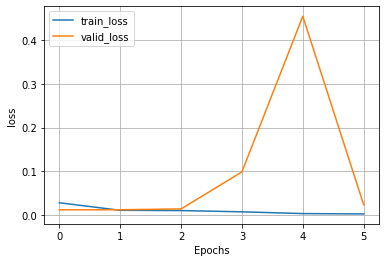

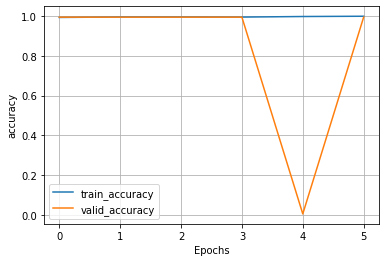

In [35]:
plot(history)
plot(history, metric="accuracy")

Test Loss 0.022814226746559144 and Test Accuracy 0.994375


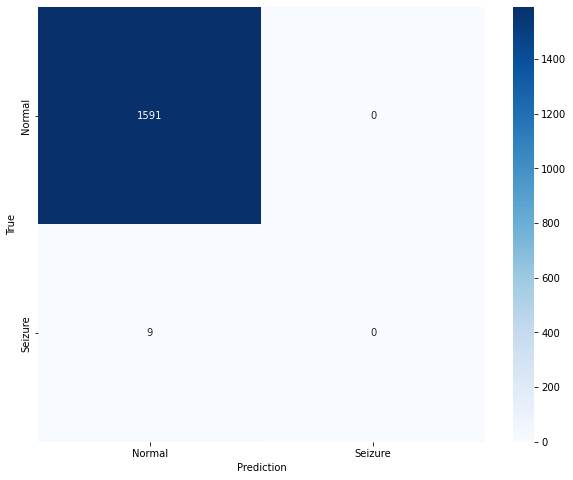

In [36]:
# eval 
history_eval, confusion_matrix,y_pred,y =  eval(loss_fn,model_lstm, test_loader,device=device)
plot_confusion_matrix(confusion_matrix, ["Normal", "Seizure"])



In [31]:
torch.cuda.empty_cache()

In [ ]:
# save the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                  exist_ok=True)

MODEL_NAME = "model_ch23.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_t.state_dict(),
           f=MODEL_SAVE_PATH)

In [53]:
len(all_data)
len(all_labels)

2